# CNN Classifier Based Retrieval technique (CCBR)

In [23]:
import sys
sys.path.append('/Users/jinjishen/Desktop/fashion-dataset')
from imports import *

In [24]:
# Custom Dataset Class for Loading Images
class FashionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx]['class_label']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Step 1: Define the CNN Model using a pre-trained ResNet50 model
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        # Using ResNet50 pre-trained model
        self.resnet = models.resnet50(pretrained=True)
        # Replace the last fully connected layer with one that matches the number of classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

    def extract_features(self, x):
        # Get features before the final classification layer
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.resnet.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        return x

# Function to train the CNN classifier
def train_cnn_classifier(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Evaluation on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

# Data preparation function
def prepare_data(df, num_classes, batch_size=32, test_size=0.2):
    le = LabelEncoder()
    df['class_label'] = le.fit_transform(df['masterCategory'])  # Encode masterCategory as class label

    train_df, test_df = train_test_split(df, test_size=test_size, stratify=df['class_label'], random_state=42)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = FashionDataset(train_df, transform=transform)
    test_dataset = FashionDataset(test_df, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, le

# Generate Feature Representations Using the Classifier Model
def extract_features(image_path, model):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = preprocess(img).unsqueeze(0)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        img_tensor = img_tensor.to(device)
        model = model.to(device)
        with torch.no_grad():
            features = model.extract_features(img_tensor).cpu().numpy().flatten()
        return features / np.linalg.norm(features)
    except FileNotFoundError:
        print(f"File not found: {image_path}")
        return None

def generate_features(df, model, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    dataset = FashionDataset(df, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)
    
    features = []
    labels = []
    paths = []
    with torch.no_grad():
        for images, label in loader:
            images = images.to(device)
            feature = model.extract_features(images).cpu().numpy()
            features.append(feature)
            labels.extend(label.numpy())
            paths.extend(df['path'])
    
    return np.vstack(features), labels, paths

In [25]:
# Function to retrieve similar images based on cosine similarity
def retrieve_similar_images(input_feature, features, labels, input_label, k=10):
    """
    Retrieve similar images based on the predicted class using cosine similarity.
    
    Parameters:
    - input_feature (numpy array): Feature vector of the input image.
    - features (numpy array): Feature vectors of all images in the dataset.
    - labels (list): True labels of all images in the dataset.
    - input_label (int): Predicted class label of the input image.
    - k (int): Number of similar images to retrieve (default: 10).
    
    Returns:
    - List of indices of the top K similar images.
    """
    same_class_indices = [i for i, label in enumerate(labels) if label == input_label]
    same_class_features = features[same_class_indices]
    similarities = cosine_similarity([input_feature], same_class_features)[0]
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    return [same_class_indices[i] for i in top_k_indices]

# Function to plot similar images along with the input image
def plot_similar_images(input_image_path, top_k_indices, df, input_image_id=None):
    """
    Plot the input image along with the top K similar product images and their product IDs.

    Parameters:
    - input_image_path (str): Path to the input image to be displayed.
    - top_k_indices (list): List of indices of the top K similar products.
    - df (pd.DataFrame): DataFrame containing product IDs and image paths.
    - input_image_id (str or int): ID of the input image to be displayed with the input image (optional).
    """
    num_images = len(top_k_indices)
    plt.figure(figsize=(15, 5))

    # Plot input image with ID if provided
    img = Image.open(input_image_path)
    plt.subplot(1, num_images + 1, 1)
    plt.imshow(img)
    title = "Input Image"
    if input_image_id is not None:
        title += f"\nID: {input_image_id}"
    plt.title(title)
    plt.axis('off')

    # Plot similar images
    for i, idx in enumerate(top_k_indices, start=2):
        img_path = df.iloc[idx]['path']
        product_id = df.iloc[idx]['id']
        img = Image.open(img_path)
        plt.subplot(1, num_images + 1, i)
        plt.imshow(img)
        plt.title(f"ID: {product_id}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Function to visualize t-SNE with true and predicted labels
def visualize_tsne_with_labels(features, true_labels, predicted_labels, title='t-SNE Visualization'):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
    tsne_results = tsne.fit_transform(features)
    
    plt.figure(figsize=(16, 8))
    
    # True Labels
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=true_labels,
        palette=sns.color_palette("hsv", len(set(true_labels))),
        legend="full",
        alpha=0.8
    )
    plt.title(f'{title} - True Labels')
    plt.legend(loc='best', bbox_to_anchor=(1, 1))

    # Predicted Labels
    plt.subplot(1, 2, 2)
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=predicted_labels,
        palette=sns.color_palette("hsv", len(set(predicted_labels))),
        legend="full",
        alpha=0.8
    )
    plt.title(f'{title} - Predicted Labels')
    plt.legend(loc='best', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

# Function to evaluate the CNN classifier 
def evaluate_classifier(model, test_loader, label_encoder):
    """
    Evaluate the CNN classifier on the test set and print accuracy and classification report.

    Parameters:
    - model (nn.Module): Trained CNN model.
    - test_loader (DataLoader): DataLoader for the test set.
    - label_encoder (LabelEncoder): Encoder used for labels.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = label_encoder.inverse_transform(all_preds)
    all_labels = label_encoder.inverse_transform(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy:.4f}')
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=label_encoder.classes_)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [28]:
# Main pipeline for CCBR with t-SNE visualization and evaluation
def cnn_classifier_based_retrieval_with_tsne(df, num_classes, k=10, num_samples=3, batch_size=32, num_epochs=10):
    # Define the device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Step 1: Prepare data and train CNN model
    print("Preparing data and training CNN model...")
    train_loader, test_loader, le = prepare_data(df, num_classes, batch_size=batch_size)
    model = CNNClassifier(num_classes=num_classes).to(device)  # Move model to device
    class_weights = compute_class_weight('balanced', classes=np.unique(df['class_label']), y=df['class_label'])
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=0.0001)
    train_cnn_classifier(model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs)
    
    # Step 2: Evaluate the model on the test set
    print("Evaluating the classifier...")
    evaluate_classifier(model, test_loader, le)
    
    # Step 3: Generate features for entire dataset using the trained model
    print("Generating features for the entire dataset...")
    all_features, all_labels, all_paths = generate_features(df, model)
    
    # Predict labels for the entire dataset
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for img_path in df['path']:
            img_tensor = extract_features(img_path, model)
            img_tensor = torch.tensor(img_tensor).unsqueeze(0).to(device)
            output = model(img_tensor).cpu()
            predicted_label = torch.argmax(output).item()
            predicted_labels.append(le.inverse_transform([predicted_label])[0])
    
    # Visualize t-SNE with true and predicted labels
    print("Visualizing t-SNE with true and predicted labels...")
    visualize_tsne_with_labels(all_features, le.inverse_transform(all_labels), predicted_labels, title='CNN Classifier-Based Retrieval')
    
    # Step 4: Randomly select images for recommendation
    print("Generating image recommendations...")
    random_images = df['path'].sample(num_samples).values
    for img_path in random_images:
        # Predict class of the input image
        input_embedding = extract_features(img_path, model)
        input_index = df[df['path'] == img_path].index[0]
        input_label = all_labels[input_index]
        
        # Retrieve similar images based on the predicted class
        top_k_indices = retrieve_similar_images(input_embedding, all_features, all_labels, input_label, k=k)
        
        # Plot the input image and its top K recommendations
        plot_similar_images(img_path, top_k_indices, df, input_image_id=df.iloc[input_index]['id'])

Dataset loaded successfully. Total samples: 4440
Using device: cpu
Preparing data and training CNN model...


/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 0.5350, Accuracy: 94.37%
Epoch [2/5], Loss: 0.2882, Accuracy: 93.69%
Epoch [3/5], Loss: 0.1418, Accuracy: 97.97%
Epoch [4/5], Loss: 0.1192, Accuracy: 93.24%
Epoch [5/5], Loss: 0.0548, Accuracy: 97.18%
Evaluating the classifier...
Accuracy: 0.9718

Classification Report:
               precision    recall  f1-score   support

  Accessories       0.99      0.90      0.94       225
      Apparel       1.00      1.00      1.00       428
     Footwear       1.00      0.99      1.00       185
   Free Items       0.05      0.50      0.10         2
Personal Care       0.96      1.00      0.98        48

     accuracy                           0.97       888
    macro avg       0.80      0.88      0.80       888
 weighted avg       0.99      0.97      0.98       888



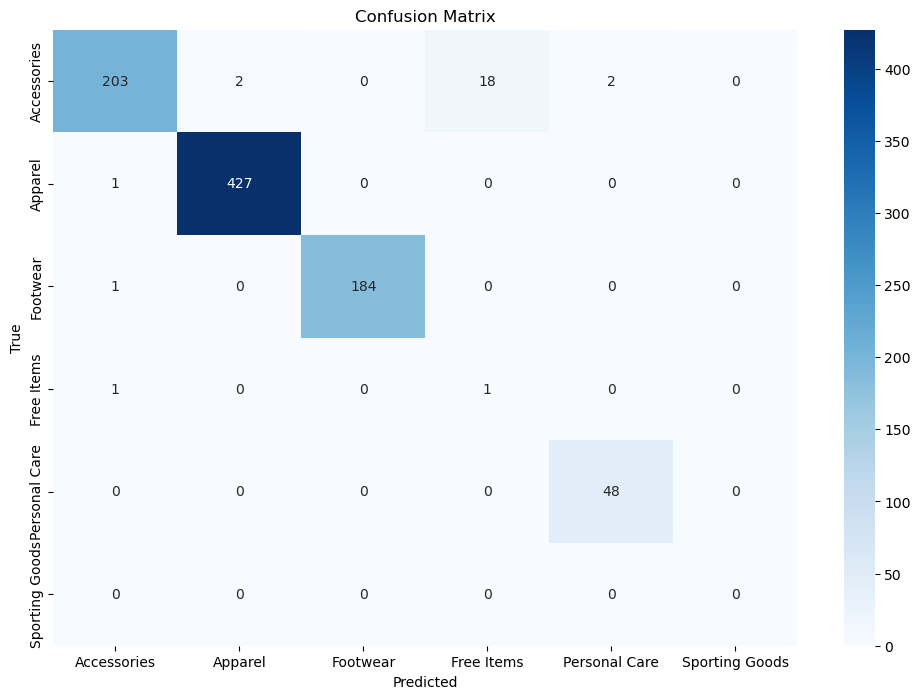

Generating features for the entire dataset...


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 2048]

In [29]:
if __name__ == "__main__":
    # Load dataset
    try:
        sampled_df = pd.read_csv('/Users/jinjishen/Desktop/fashion-dataset/sampled_df.csv')
        sampled_df = sampled_df[sampled_df['id'] != 39410].reset_index(drop=True)  # Remove missing image
        print(f"Dataset loaded successfully. Total samples: {len(sampled_df)}")
    except FileNotFoundError:
        print("The file path specified does not exist. Please check the file path and try again.")
        exit()
    
    # Run the main pipeline for CNN Classifier-Based Retrieval with t-SNE visualization
    cnn_classifier_based_retrieval_with_tsne(
        df=sampled_df,
        num_classes=sampled_df['masterCategory'].nunique(),
        k=10,
        num_samples=3,
        batch_size=32,
        num_epochs=5  # Reduced epochs for quick testing; adjust as necessary
    )